# Project 3 AML


In [61]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import itertools
import matplotlib.pyplot as plt
from biosppy import ecg
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier

In [11]:
debug = 1
if debug:
    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    print('Debug mode activated')
    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    # Chose some random samples to load
    rng = np.random.default_rng(seed=1)
    skip = rng.choice(np.arange(1, 5118, step=1), size=5107, replace=False)
    # skip = np.arange(1, 5118, step=1).tolist()
    x_train = pd.read_csv('raw/X_train.csv', sep=',', index_col='id', skiprows=skip)
    y_train = pd.read_csv('raw/y_train.csv', sep=',', index_col='id', skiprows=skip)
else:
    x_test = pd.read_csv('raw/X_test.csv', sep=',', index_col='id')
    x_train = pd.read_csv('raw/X_train.csv', sep=',', index_col='id')
    y_train = pd.read_csv('raw/y_train.csv', sep=',', index_col='id')

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Debug mode activated
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


## Feature engineering
# Method 1

In [ ]:
def extract_template_info(template):
    # Don't really know what this does. Inspired by Aur. Think its something like
    # safely dermining position of R peak and so on.
    peak = np.amax(template)
    idx_peak = np.argmax(template)

    if idx_peak == 0:
        low_before = peak
        idx_low_before = idx_peak
    else:
        low_before = np.amin(template[:idx_peak])
        idx_low_before = np.argmin(template[:idx_peak])

    if idx_peak == 179:
        low_after = peak
        idx_low_after = idx_peak
    else:
        low_after = np.amin(template[idx_peak:])
        idx_low_after = idx_peak + np.argmin(template[idx_peak:])

    if idx_low_before == 0:
        peak_before = low_before
        idx_peak_before = idx_low_before
    else:
        peak_before = np.amax(template[:idx_low_before])
        idx_peak_before = np.argmax(template[:idx_low_before])

    if idx_low_after == 179:
        peak_after = low_after
        idx_peak_after = idx_low_after
    else:
        peak_after = np.amax(template[idx_low_after:])
        idx_peak_after = idx_low_after + np.argmax(template[idx_low_after:])

    if idx_peak_before == 0:
        low_before_before = peak_before
        idx_low_before_before = idx_peak_before
    else:
        low_before_before = np.amin(template[:idx_peak_before])
        idx_low_before_before = np.argmin(template[:idx_peak_before])

    if idx_peak_after == 179:
        low_after_after = peak_after
        idx_low_after_after = idx_peak_after
    else:
        low_after_after = np.amin(template[idx_peak_after:])
        idx_low_after_after = idx_peak_after + np.argmin(
            template[idx_peak_after:]
        )

    assert idx_low_before_before <= idx_peak_before
    assert idx_peak_before <= idx_low_before
    assert idx_low_before <= idx_peak
    assert idx_peak <= idx_low_after
    assert idx_low_after <= idx_peak_after
    assert idx_peak_after <= idx_low_after_after

    values = [low_before_before, peak_before, low_before, peak, low_after,
              peak_after, low_after_after]
    indices = [idx_low_before_before, idx_peak_before, idx_low_before,
               idx_peak, idx_low_after, idx_peak_after, idx_low_after_after]
    diff_val = [cmb[0] - cmb[1] for cmb in itertools.combinations(values, 2)]
    diff_idx = [cmb[0] - cmb[1] for cmb in itertools.combinations(indices, 2)]

    return np.array(values + indices + diff_val + diff_idx)

In [7]:
def extract(x):
    features = []
    for index, row in x.iterrows():
        row = row.dropna()
        ecg_info = ecg.ecg(row.values, sampling_rate=300, show=False)
        templates = ecg_info[4]
        template_values = []

        for i in range(templates.shape[0]):
            template_values.append(extract_template_info(templates[i, :]))

        template_values = np.vstack(template_values)

        series_features = []
        series_features.extend(np.mean(template_values, axis=0).tolist())  # Mean extracts the average heartbeat
        series_features.extend(np.var(template_values, axis=0).tolist())
        series_features.extend(np.median(template_values, axis=0).tolist())
        series_features.extend(np.amin(template_values, axis=0).tolist())
        series_features.extend(np.amax(template_values, axis=0).tolist())
        mean_template = np.mean(templates, axis=0)
        series_features.extend(extract_template_info(mean_template).tolist())

        features.append(np.array(series_features))
    return np.vstack(features)

In [ ]:
feat_train = extract(x_train)
np.savetxt('feat/features_train_temp_only.csv', feat_train, delimiter=',', fmt='%s')
feat_test = extract(x_test)
np.savetxt('feat/features_test_temp_only.csv', feat_test, delimiter=',', fmt='%s')


### Method 2

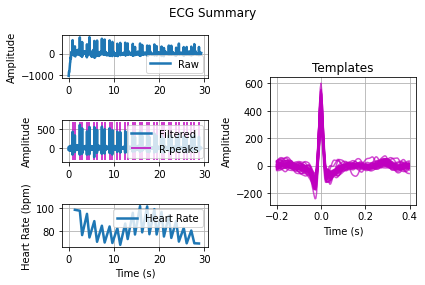

(17979,)


In [43]:
row = x_train.iloc[0]
currentPatient = row.dropna().values
ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg.ecg(currentPatient, sampling_rate=300, show=True)
R_Peaks = filtered[rpeaks]
print(row.shape)
# Process the signals
# Preprocess the data (filter, find peaks, etc.)
processed_data, info = nk.ecg_process(ecg_signal=currentPatient, sampling_rate=300)

# Compute relevant features
results = nk.bio_analyze(processed_data, sampling_rate=300)


In [ ]:
def exctract_feat(x):
    assert(isinstance(x, pd.DataFrame))
    noSamples = x.shape[0]
    numberOfFeatures = 43

    preprocessed_X_train = np.empty([numberOfTestSamples, numberOfFeatures])

    features_names_timehvr = ['sdNN', 'meanNN', 'CVSD', 'cvNN', 'RMSSD', 'medianNN',
                            'madNN', 'mcvNN', 'pNN50', 'pNN20']

    # features_names_freqhvr = ['Triang', 'Shannon_h', 'VLF', 'LF', 'HF', 'Total_Power',
    #                             'LF/HF', 'LFn', 'HFn', 'LF/P', 'HF/P', 'ULF', 'VHF']

    features_names_freqhvr = ['ULF', 'VLF', 'LF', 'HF', 'VHF', 'Total', 'extra1', 'extra2', 
                            'extra3', 'extra4', 'extra5', 'corr_max', 'corr_min', 'corr1', 'corr2', 'corr3']
    for i, row in x.iterrows():
        if i % 500 == 0:
            print(i)

        # Create an empty arrray, features will be appended to this
        features = np.empty([1,0])
        # Get the current signal
        currentPatient = row.dropna().values
        # preproces the signal, it returns a dictionary
        ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg.ecg(currentPatient, sampling_rate=300, show=False)

        # if heart_rate.size == 0:
        #     print('array is empty at index: ', i)

        # add mean, max, min, median, std of r amplitudes
        R_Peaks = filtered[rpeaks]

        mean_rvalues = np.mean(R_Peaks)
        min_rvalues = np.min(R_Peaks)
        max_rvalues = np.max(R_Peaks)
        std_rvalues = np.std(R_Peaks)
        median_rvalues = np.median(R_Peaks)

        means_of_r = np.empty([1, 5])
        means_of_r[0, :] = [mean_rvalues, min_rvalues, max_rvalues, std_rvalues, median_rvalues]
        features = np.append(features, means_of_r, axis=1)

        # add mean, max, min, median, std of heart rates
        # mean_hr = np.mean(heart_rate)
        # max_hr = np.mean(heart_rate)
        # min_hr = np.mean(heart_rate)
        # median_hr = np.mean(heart_rate)
        # std_hr = np.mean(heart_rate)

        # heart_rate_features = np.empty([1,5])
        # heart_rate_features[0,:] = [mean_hr, max_hr, min_hr, median_hr, std_hr]
        # features = np.append(features, heart_rate_features, axis=1)

        # add power
        power = np.sum(np.square(filtered)) / filtered.shape[0]
        features = np.append(features, power.reshape(1,-1), axis=1)



        Cardiadic_Cycles = pd.DataFrame(templates)


        # add the mean, mean-max, mean-min, mean-std, mean-median of cardiac cycles
        mean = Cardiadic_Cycles.mean(axis=0).mean()
        mean_max = Cardiadic_Cycles.max(axis=0).mean()
        mean_min = Cardiadic_Cycles.min(axis=0).mean()
        mean_median = Cardiadic_Cycles.median(axis=0).mean()
        mean_std = Cardiadic_Cycles.std(axis=0).mean()

        max_min = Cardiadic_Cycles.min(axis=0).max()
        min_min = Cardiadic_Cycles.min(axis=0).min()

        max_max = Cardiadic_Cycles.max(axis=0).max()
        min_max = Cardiadic_Cycles.max(axis=0).min()

        max_std = Cardiadic_Cycles.std(axis=0).max()
        min_std = Cardiadic_Cycles.std(axis=0).min()

        to_add = np.empty([1,11])
        to_add[0, :] = [mean, mean_max, mean_min, mean_median, mean_std, max_min, min_min, max_max, min_max, max_std, min_std]

        features= np.append(features, to_add, axis=1)    


        # Addition of time hvr features
        hvr_time_features = nkcopy.ecg_hrv(rpeaks=rpeaks, sampling_rate=300, hrv_features='time')
        # add all time hvr to array features
        for feature in features_names_timehvr:
            features = np.append(features, hvr_time_features[feature])

        # Addition of frequency features
        #hvr_freq_features = frequency_analysis.get_frequency_features(templates)
        ## add all frequency hvr to array features
        #for feature in features_names_freqhvr:
        #    features = np.append(features, hvr_freq_features[feature])

        preprocessed_X_train[i,:] = features

    np.save('preprocessed_X_test_43', preprocessed_X_train)

In [ ]:
feat_train = exctract_feat(x_train)
np.savetxt('feat2/train.csv', feat_train, delimiter=',', fmt='%s')
feat_test = exctract_feat(x_test)
np.savetxt('feat2/test.csv', feat_test, delimiter=',', fmt='%s')

### Method Dan

Find QPST peaks and store. Copied from neurokit ecg. Added return of value of peaks( the stuff with _val). I think the index in the current heartbeat (as to the index in the entire signal) gets retured. But this could be an advantage?

In [121]:
from neurokit2.ecg.ecg_segment import ecg_segment
def ecg_delineator_peak(ecg, rpeaks=None, sampling_rate=1000):

    # Initialize
    heartbeats = ecg_segment(ecg, rpeaks, sampling_rate)

    Q_list = []
    P_list = []
    S_list = []
    T_list = []
    
    Q_list_val = []
    P_list_val = []
    S_list_val = []
    T_list_val = []

    P_onsets = []
    T_offsets = []

    for i, rpeak in enumerate(rpeaks):
        heartbeat = heartbeats[str(i + 1)]

        # Get index of heartbeat
        R = heartbeat.index.get_loc(np.min(heartbeat.index.values[heartbeat.index.values > 0]))

        # Peaks ------
        # Q wave
        Q_index, Q = _ecg_delineator_peak_Q(rpeak, heartbeat, R)
        Q_list.append(Q_index)
        Q_list_val.append(Q)
        
        # P wave
        P_index, P = _ecg_delineator_peak_P(rpeak, heartbeat, R, Q)
        P_list.append(P_index)
        P_list_val.append(P)

        # S wave
        S_index, S = _ecg_delineator_peak_S(rpeak, heartbeat)
        S_list.append(S_index)
        S_list_val.append(S)

        # T wave
        T_index, T = _ecg_delineator_peak_T(rpeak, heartbeat, R, S)
        T_list.append(T_index)
        T_list_val.append(T)

        # Onsets/Offsets ------
        P_onsets.append(_ecg_delineator_peak_P_onset(rpeak, heartbeat, R, P))
        T_offsets.append(_ecg_delineator_peak_T_offset(rpeak, heartbeat, R, T))
    # Return info dictionary
    return {
        "ECG_P_Peaks": P_list,
        "ECG_Q_Peaks": Q_list,
        "ECG_S_Peaks": S_list,
        "ECG_T_Peaks": T_list,
        "ECG_P_Peaks_Val": P_list,
        "ECG_Q_Peaks_Val": Q_list,
        "ECG_S_Peaks_Val": S_list,
        "ECG_T_Peaks_Val": T_list,
        "ECG_P_Onsets": P_onsets,
        "ECG_T_Offsets": T_offsets,
    }
# --------------------------
# Internal
# --------------------------


def _ecg_delineator_peak_Q(rpeak, heartbeat, R):
    segment = heartbeat[:0]  # Select left hand side

    Q = signal_findpeaks(-1 * segment["Signal"], height_min=0.05 * (segment["Signal"].max() - segment["Signal"].min()))
    if len(Q["Peaks"]) == 0:
        return np.nan, None
    Q = Q["Peaks"][-1]  # Select most right-hand side
    from_R = R - Q  # Relative to R
    return rpeak - from_R, Q


def _ecg_delineator_peak_P(rpeak, heartbeat, R, Q):
    if Q is None:
        return np.nan, None

    segment = heartbeat.iloc[:Q]  # Select left of Q wave
    P = signal_findpeaks(segment["Signal"], height_min=0.05 * (segment["Signal"].max() - segment["Signal"].min()))

    if len(P["Peaks"]) == 0:
        return np.nan, None
    P = P["Peaks"][np.argmax(P["Height"])]  # Select heighest
    from_R = R - P  # Relative to R
    return rpeak - from_R, P


def _ecg_delineator_peak_S(rpeak, heartbeat):
    segment = heartbeat[0:]  # Select right hand side
    S = signal_findpeaks(-segment["Signal"], height_min=0.05 * (segment["Signal"].max() - segment["Signal"].min()))

    if len(S["Peaks"]) == 0:
        return np.nan, None
    S = S["Peaks"][0]  # Select most left-hand side
    return rpeak + S, S


def _ecg_delineator_peak_T(rpeak, heartbeat, R, S):
    if S is None:
        return np.nan, None

    segment = heartbeat.iloc[R + S :]  # Select right of S wave
    T = signal_findpeaks(segment["Signal"], height_min=0.05 * (segment["Signal"].max() - segment["Signal"].min()))

    if len(T["Peaks"]) == 0:
        return np.nan, None
    T = S + T["Peaks"][np.argmax(T["Height"])]  # Select heighest
    return rpeak + T, T


def _ecg_delineator_peak_P_onset(rpeak, heartbeat, R, P):
    if P is None:
        return np.nan

    segment = heartbeat.iloc[:P]  # Select left of P wave
    try:
        signal = signal_smooth(segment["Signal"].values, size=R / 10)
    except TypeError:
        signal = segment["Signal"]

    if len(signal) < 2:
        return np.nan

    signal = np.gradient(np.gradient(signal))
    P_onset = np.argmax(signal)

    from_R = R - P_onset  # Relative to R
    return rpeak - from_R


def _ecg_delineator_peak_T_offset(rpeak, heartbeat, R, T):
    if T is None:
        return np.nan

    segment = heartbeat.iloc[R + T :]  # Select left of P wave
    try:
        signal = signal_smooth(segment["Signal"].values, size=R / 10)
    except TypeError:
        signal = segment["Signal"]

    if len(signal) < 2:
        return np.nan

    signal = np.gradient(np.gradient(signal))
    T_offset = np.argmax(signal)

    return rpeak + T + T_offset

In [115]:
import pandas as pd

from neurokit2.signal import signal_rate, signal_sanitize
from neurokit2.ecg.ecg_clean import ecg_clean
from neurokit2.ecg.ecg_delineate import ecg_delineate
from neurokit2.ecg.ecg_peaks import ecg_peaks
from neurokit2.ecg.ecg_phase import ecg_phase
from neurokit2.ecg.ecg_quality import ecg_quality


def ecg_process(ecg_signal, sampling_rate=300, method="neurokit"):
    """Process an ECG signal.
    Convenience function that automatically processes an ECG signal.
    Parameters
    ----------
    ecg_signal : Union[list, np.array, pd.Series]
        The raw ECG channel.
    sampling_rate : int
        The sampling frequency of `ecg_signal` (in Hz, i.e., samples/second).
        Defaults to 1000.
    method : str
        The processing pipeline to apply. Defaults to "neurokit".
    Returns
    -------
    signals : DataFrame
        A DataFrame of the same length as the `ecg_signal` containing the following columns:
        - *"ECG_Raw"*: the raw signal.
        - *"ECG_Clean"*: the cleaned signal.
        - *"ECG_R_Peaks"*: the R-peaks marked as "1" in a list of zeros.
        - *"ECG_Rate"*: heart rate interpolated between R-peaks.
        - *"ECG_P_Peaks"*: the P-peaks marked as "1" in a list of zeros
        - *"ECG_Q_Peaks"*: the Q-peaks marked as "1" in a list of zeros .
        - *"ECG_S_Peaks"*: the S-peaks marked as "1" in a list of zeros.
        - *"ECG_T_Peaks"*: the T-peaks marked as "1" in a list of zeros.
        - *"ECG_P_Onsets"*: the P-onsets marked as "1" in a list of zeros.
        - *"ECG_P_Offsets"*: the P-offsets marked as "1" in a list of zeros
                            (only when method in `ecg_delineate` is wavelet).
        - *"ECG_T_Onsets"*: the T-onsets marked as "1" in a list of zeros
                            (only when method in `ecg_delineate` is wavelet).
        - *"ECG_T_Offsets"*: the T-offsets marked as "1" in a list of zeros.
        - *"ECG_R_Onsets"*: the R-onsets marked as "1" in a list of zeros
                            (only when method in `ecg_delineate` is wavelet).
        - *"ECG_R_Offsets"*: the R-offsets marked as "1" in a list of zeros
                            (only when method in `ecg_delineate` is wavelet).
        - *"ECG_Phase_Atrial"*: cardiac phase, marked by "1" for systole
          and "0" for diastole.
        - *"ECG_Phase_Ventricular"*: cardiac phase, marked by "1" for systole and "0" for diastole.
        - *"ECG_Atrial_PhaseCompletion"*: cardiac phase (atrial) completion, expressed in percentage
          (from 0 to 1), representing the stage of the current cardiac phase.
        - *"ECG_Ventricular_PhaseCompletion"*: cardiac phase (ventricular) completion, expressed in
          percentage (from 0 to 1), representing the stage of the current cardiac phase.
    info : dict
        A dictionary containing the samples at which the R-peaks occur, accessible with the key
        "ECG_Peaks".
    See Also
    --------
    ecg_clean, ecg_findpeaks, ecg_plot, signal_rate, signal_fixpeaks
    Examples
    --------
    >>> import neurokit2 as nk
    >>>
    >>> ecg = nk.ecg_simulate(duration=15, sampling_rate=1000, heart_rate=80)
    >>> signals, info = nk.ecg_process(ecg, sampling_rate=1000)
    >>> nk.ecg_plot(signals) #doctest: +ELLIPSIS
    <Figure ...>
    """
    # Sanitize input
    ecg_signal = signal_sanitize(ecg_signal)

    ecg_cleaned = ecg_clean(ecg_signal, sampling_rate=sampling_rate, method=method)
    
    # R-peaks
    instant_peaks, rpeaks, = ecg_peaks(
        ecg_cleaned=ecg_cleaned, sampling_rate=sampling_rate, method=method, correct_artifacts=True
    )

    rate = signal_rate(rpeaks, sampling_rate=sampling_rate, desired_length=len(ecg_cleaned))

    quality = ecg_quality(ecg_cleaned, rpeaks=None, sampling_rate=sampling_rate)

    signals = pd.DataFrame({"ECG_Raw": ecg_signal, "ECG_Clean": ecg_cleaned, "ECG_Rate": rate, "ECG_Quality": quality})

    # Additional info of the ecg signal
    waves = ecg_delineator_peak(ecg_cleaned, rpeaks=rpeaks, sampling_rate=sampling_rate)
    # Remove NaN in Peaks, Onsets, and Offsets
    waves_noNA = waves.copy()
    for feature in waves_noNA.keys():
        waves_noNA[feature] = [int(x) for x in waves_noNA[feature] if ~np.isnan(x)]
    delineate_signal = pd.DataFrame.from_dict(waves) 
    
    signals = pd.concat([signals, instant_peaks], axis=1)
    
    return signals, rpeaks, delineate_signal

In [48]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd

from neurokit2.hrv import hrv


def ecg_intervalrelated(data, sampling_rate=1000):
    """Performs ECG analysis on longer periods of data (typically > 10 seconds), such as resting-state data.
    Parameters
    ----------
    data : Union[dict, pd.DataFrame]
        A DataFrame containing the different processed signal(s) as different columns, typically
        generated by `ecg_process()` or `bio_process()`. Can also take a dict containing sets of
        separately processed DataFrames.
    sampling_rate : int
        The sampling frequency of the signal (in Hz, i.e., samples/second).
    Returns
    -------
    DataFrame
        A dataframe containing the analyzed ECG features. The analyzed features consist of the following:
        - *"ECG_Rate_Mean"*: the mean heart rate.
        - *"ECG_HRV"*: the different heart rate variability metrices.
        See `hrv_summary()` docstrings for details.
    See Also
    --------
    bio_process, ecg_eventrelated
    Examples
    ----------
    >>> import neurokit2 as nk
    >>>
    >>> # Download data
    >>> data = nk.data("bio_resting_5min_100hz")
    >>>
    >>> # Process the data
    >>> df, info = nk.ecg_process(data["ECG"], sampling_rate=100)
    >>>
    >>> # Single dataframe is passed
    >>> nk.ecg_intervalrelated(df, sampling_rate=100) #doctest: +ELLIPSIS
       ECG_Rate_Mean  HRV_RMSSD  ...
    0      ...
    [1 rows x 55 columns]
    >>>
    >>> epochs = nk.epochs_create(df, events=[0, 15000], sampling_rate=100,
    ...                           epochs_end=150)
    >>> nk.ecg_intervalrelated(epochs) #doctest: +ELLIPSIS
       ECG_Rate_Mean  HRV_RMSSD ...
    1      ...
    [2 rows x 55 columns]
    """
    intervals = {}

    # Format input
    if isinstance(data, pd.DataFrame):
        rate_cols = [col for col in data.columns if "ECG_Rate" in col]
        if len(rate_cols) == 1:
            intervals.update(_ecg_intervalrelated_formatinput(data))
            intervals.update(_ecg_intervalrelated_hrv(data, sampling_rate))
        else:
            raise ValueError(
                "NeuroKit error: ecg_intervalrelated(): Wrong input,"
                "we couldn't extract heart rate. Please make sure"
                "your DataFrame contains an `ECG_Rate` column."
            )
        ecg_intervals = pd.DataFrame.from_dict(intervals, orient="index").T

    elif isinstance(data, dict):
        for index in data:
            intervals[index] = {}  # Initialize empty container

            # Format dataframe
            data[index] = data[index].set_index("Index").drop(["Label"], axis=1)

            # Rate
            intervals[index] = _ecg_intervalrelated_formatinput(data[index], intervals[index])

            # HRV
            intervals[index] = _ecg_intervalrelated_hrv(data[index], sampling_rate, intervals[index])

        ecg_intervals = pd.DataFrame.from_dict(intervals, orient="index")

    return ecg_intervals


# =============================================================================
# Internals
# =============================================================================


def _ecg_intervalrelated_formatinput(data, output={}):

    # Sanitize input
    colnames = data.columns.values
    if len([i for i in colnames if "ECG_Rate" in i]) == 0:
        raise ValueError(
            "NeuroKit error: ecg_intervalrelated(): Wrong input,"
            "we couldn't extract heart rate. Please make sure"
            "your DataFrame contains an `ECG_Rate` column."
        )
    signal = data["ECG_Rate"].values
    output["ECG_Rate_Mean"] = np.mean(signal)

    return output


def _ecg_intervalrelated_hrv(data, sampling_rate, output={}):

    # Sanitize input
    colnames = data.columns.values
    if len([i for i in colnames if "ECG_R_Peaks" in i]) == 0:
        raise ValueError(
            "NeuroKit error: ecg_intervalrelated(): Wrong input,"
            "we couldn't extract R-peaks. Please make sure"
            "your DataFrame contains an `ECG_R_Peaks` column."
        )

    # Transform rpeaks from "signal" format to "info" format.
    rpeaks = np.where(data["ECG_R_Peaks"].values)[0]
    rpeaks = {"ECG_R_Peaks": rpeaks}

    results = hrv(rpeaks, sampling_rate=sampling_rate)
    for column in results.columns:
        output[column] = float(results[column])

    return output

In [ ]:
def exctract_feat(x):
    assert(isinstance(x, pd.DataFrame))
    noSamples = x.shape[0]
    numberOfFeatures = 43

    preprocessed_X_train = np.empty([numberOfTestSamples, numberOfFeatures])

    features_names_timehvr = ['sdNN', 'meanNN', 'CVSD', 'cvNN', 'RMSSD', 'medianNN',
                            'madNN', 'mcvNN', 'pNN50', 'pNN20']

    # features_names_freqhvr = ['Triang', 'Shannon_h', 'VLF', 'LF', 'HF', 'Total_Power',
    #                             'LF/HF', 'LFn', 'HFn', 'LF/P', 'HF/P', 'ULF', 'VHF']

    features_names_freqhvr = ['ULF', 'VLF', 'LF', 'HF', 'VHF', 'Total', 'extra1', 'extra2', 
                            'extra3', 'extra4', 'extra5', 'corr_max', 'corr_min', 'corr1', 'corr2', 'corr3']
    for i, row in x.iterrows():
        if i % 500 == 0:
            print(i)
            
        method = "neurokit"
        sampling_rate = 300
        
        signals, info = ecg_process(row, sampling_rate)
        ecg_interval_features = ecg_intervalrelated(data, sampling_rate)
        #Following features mark events as 1s in lists of zeros
        #Now the time of the event and the amplitude of the event is extracted
        #What to do with
        event_features = ['ECG_R_Peaks','ECG_P_Peaks','ECG_Q_Peaks','ECG_S_Peaks','ECG_T_Peaks','ECG_P_Onsets','ECG_T_Offsets']
        for i in event_feat:
            time = signals.index[signals[i] == 1].tolist()
            signals['ECG_Clean'][time]
        
        

    np.save('preprocessed_X_test_43', preprocessed_X_train)
    
    #ecg_interval_features containing inf or nan: HRV_SampEn, HRV_ULF, HRV_VLF, HRV_LF, HRV_LFHF, HRV_LFn

{'ECG_R_Peaks': array([ 292,  534,  777, 1023, 1268, 1511, 1754, 2001, 2251, 2496, 2745,
       2996, 3246, 3495, 3739, 3978, 4219, 4457, 4696, 4934, 5170, 5403,
       5638, 5878, 6123, 6370, 6617, 6865, 7115, 7365, 7608, 7849, 8092,
       8331, 8570, 8806, 9044])}
Index(['ECG_Raw', 'ECG_Clean', 'ECG_Rate', 'ECG_Quality', 'ECG_R_Peaks',
       'ECG_P_Peaks', 'ECG_Q_Peaks', 'ECG_S_Peaks', 'ECG_T_Peaks',
       'ECG_P_Onsets', 'ECG_T_Offsets', 'ECG_Phase_Atrial',
       'ECG_Phase_Completion_Atrial', 'ECG_Phase_Ventricular',
       'ECG_Phase_Completion_Ventricular'],
      dtype='object')


<function matplotlib.pyplot.show(close=None, block=None)>

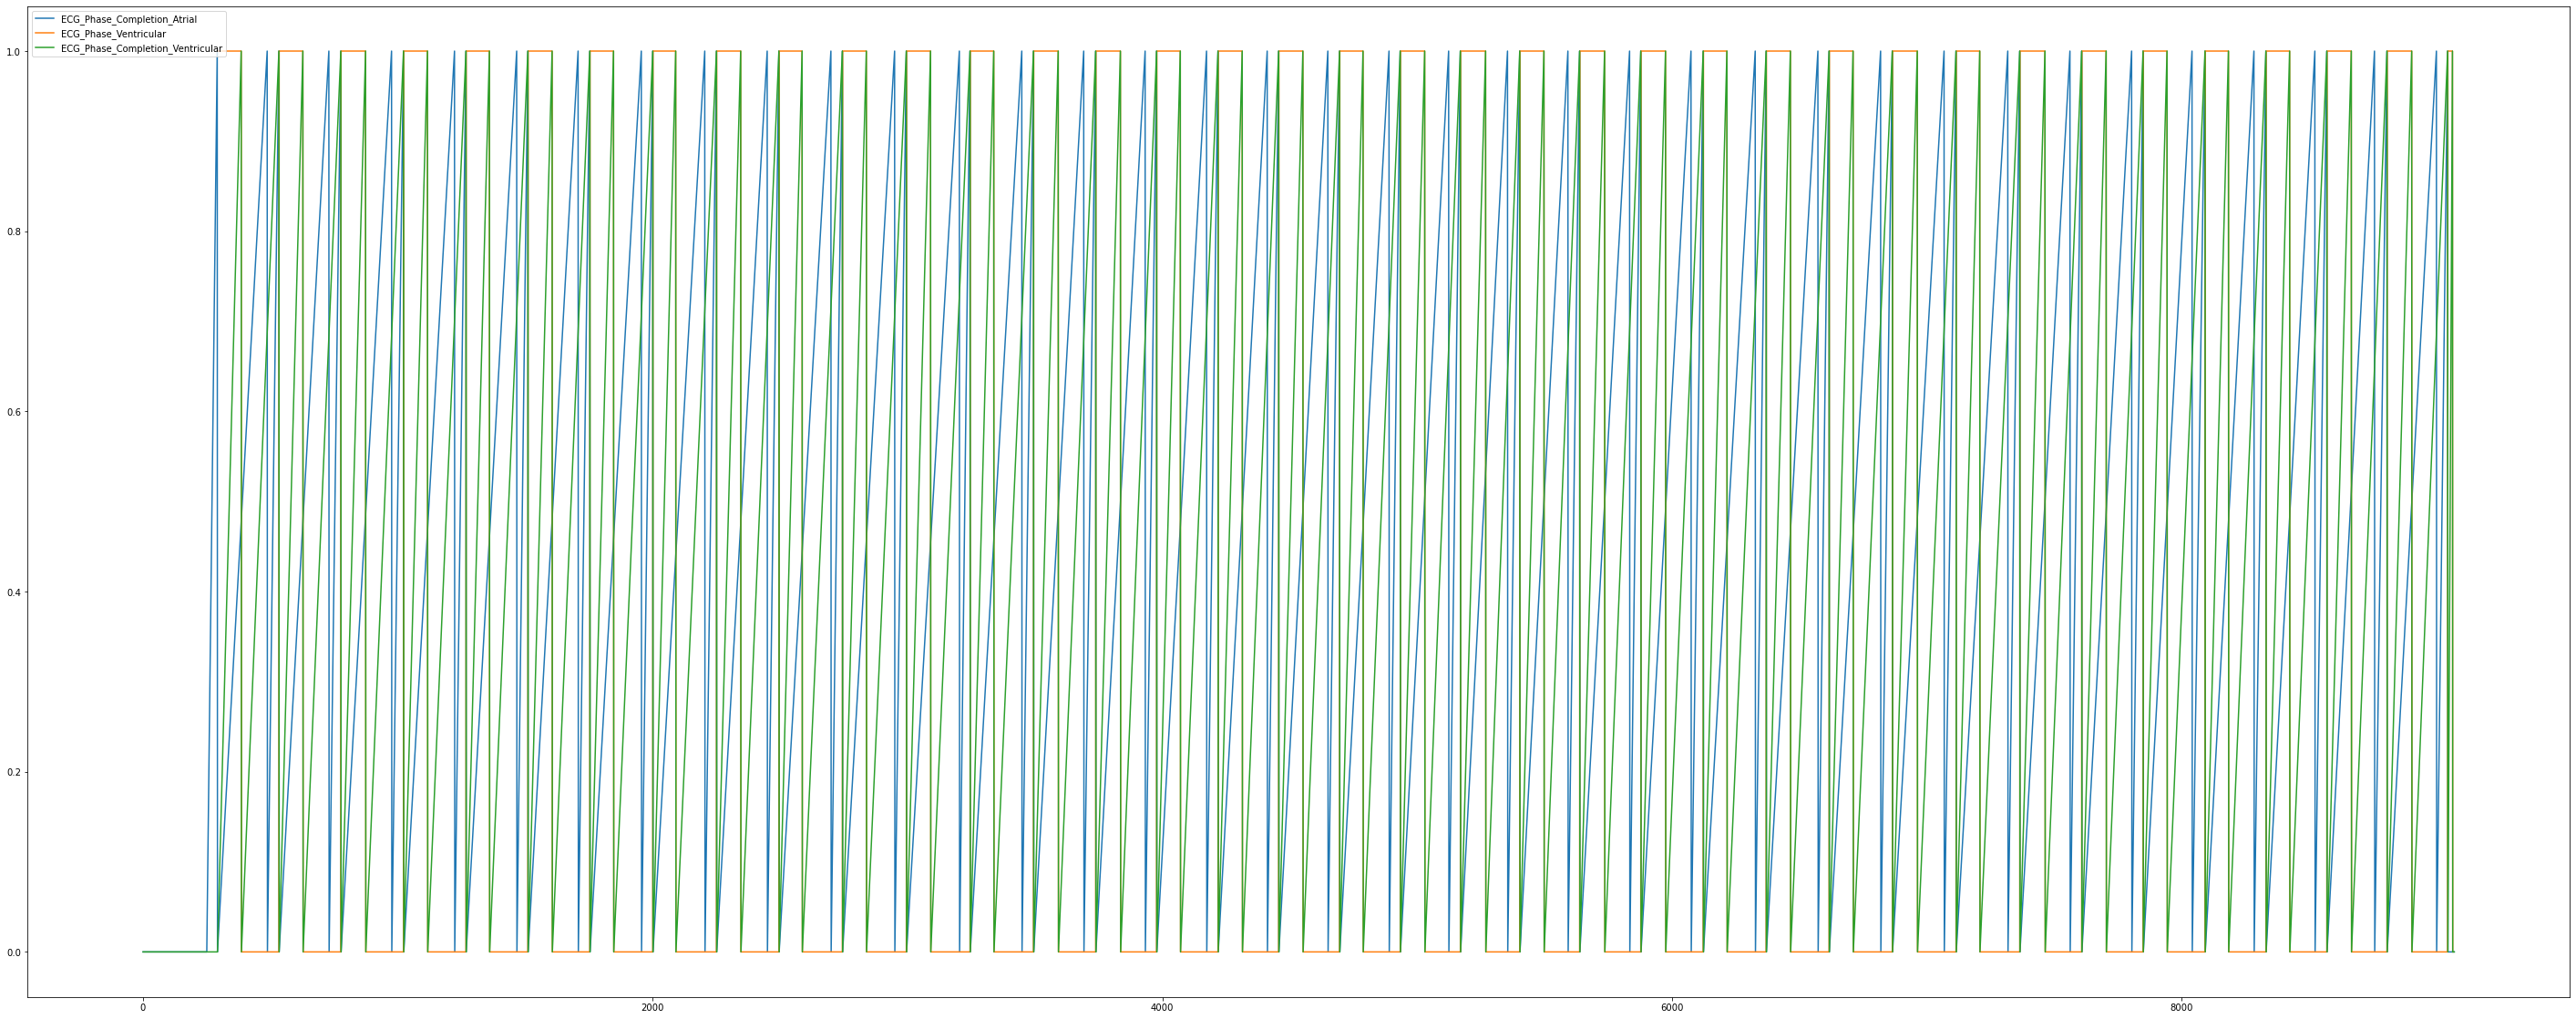

In [125]:
row = x_train.iloc[4]
currentPatient = row.dropna().values
#signals, info = ecg_process(row, 300)
signals, info= nk.ecg.ecg_process(currentPatient, 300)
#plt.plot(signals['ECG_Quality'])
#plt.show
ecg_interval_features = ecg_intervalrelated(signals, 300)
print(info)
print(signals.columns)
signals.iloc[:,12:].plot(figsize=(50, 20))
plt.legend(loc='upper left')
plt.show


## Estimation

In [6]:
if ('feat_train' in locals() and 'feat_test'in locals()):
  # myVar exists.
    X_train = feat_train
    X_test = feat_test
else:
    #load preprepared features
    X_train = np.loadtxt('feat/features_train_temp_only.csv', delimiter=',') #preprepared features
    # X_train = np.loadtxt('features_train_temp_only.csv', delimiter=',') #preprepared features
    print("*")
    X_test = np.loadtxt('feat/features_test_temp_only.csv', delimiter=',') #preprepared features
    print("*")
    print(X_test.shape)
y_train = pd.read_csv('raw/y_train.csv').drop(['id'], axis=1).values
print("*")

*
*
(3411, 336)
*
*
(3411,)


In [7]:
scaler = RobustScaler() #aendern zu normalem?
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
print("***training***")
model = XGBClassifier(objective='multi:softprob', num_class=4, n_estimators=200, max_depth=8)
model.fit(X_train, y_train.ravel())

y_pred = model.predict(X_test)
#np.hstack(Id_test, y_pred)
#out = [Id_test, y_pred] #combine ind & y val
#np.savetxt('output.csv', np.transpose(out) , delimiter=',' , header= 'id,y'  ) #print output to file

***training***


In [55]:
print(y_pred.shape)
print()
print(Id_test.shape)
#out = np.vstack((Id_test, y_pred))

out.astype('int')
y_test = pd.DataFrame(y_pred)
y_test.to_csv('prediction.csv', index_label='id', header=['y'], compression=None)

(3411,)

(3411,)


In [53]:
y_pred.shape

(3411,)

Run to create a console

In [ ]:
%qtconsole